In [62]:
import generate_data as vaina
import models
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from evaluate import *


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Sacamos el conjunto de datos de entramiento y lo dividimos en 25% del subset para entrenamiento

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Define el dispositivo que PyTorch usará para ejecutar los cálculos.

data = vaina.Data(layer_size=6)
train, val, test = data.get_splits(['random_subsample'], [[0.25, 0.75]]) #internamente onehot
train_unshuffled = train.copy()
np.random.shuffle(train)

Number of samples: 132 train | 79 val | 318 test


c:\Users\juand\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


In [5]:
data.samples

[[',..._.', 'w._,._', 'cr__._', 'V'],
 ['.,,_,.', 'w,_,__', '.cr._.', 'V'],
 [',__,._', 'w,._,.', '_,cr__', 'V'],
 [',___._', 'w.,_.,', ',..cr,', 'V'],
 ['__.,.,', 'w._,_.', '_..,cr', 'V'],
 [',,,__,', ',w._._', 'cr.,,_', 'V'],
 [',_..,_', '_w....', '.cr.__', 'V'],
 ['___.__', '_w_,_,', '..cr__', 'V'],
 ['_.,_._', '_w._.,', '...cr_', 'V'],
 ['_.,,.,', '.w...,', '__._cr', 'V'],
 [',,.,.,', '._w__,', 'cr_,_,', 'V'],
 ['_..__.', '__w_.,', ',cr,.,', 'V'],
 [',.._..', '_,w_..', '.,cr.,', 'V'],
 ['_.__,,', '_,w,_,', '__.cr.', 'V'],
 [',..,__', '.,w.,_', '.___cr', 'V'],
 [',,.._.', '...w.,', 'cr,,,,', 'V'],
 ['__,.._', '.,.w..', ',cr_.,', 'V'],
 ['_...__', '..,w__', ',_cr..', 'V'],
 ['__....', ',,,w._', '..,cr,', 'V'],
 ['..._.,', '.,_w_.', ',.__cr', 'V'],
 ['.._..,', '_.,_w,', 'cr__.,', 'V'],
 [',,,__.', '.__.w_', '_cr__,', 'V'],
 ['.___,_', '._,,w.', '__cr,,', 'V'],
 ['....__', ',..,w,', '__,cr.', 'V'],
 ['..,._,', '.__.w,', '__,,cr', 'V'],
 ['_,,_,.', '.__,_w', 'cr,_,.', 'V'],
 ['._,._,', 

Separamos todos los datos en x (variables), y (clasificacion) 

In [6]:
x_train, y_train = data.get_x_y(train) #devuelve  self.np_data = self.one_hot_encode(self.samples_char_sep)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

In [7]:
x_train[0]
#print(x_train[:10])

array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0], dtype=object)

In [8]:
print(y_train[:10])


['V' 'R' 'A' 'V' 'V' 'V' 'V' 'V' 'V' 'V']


In [9]:
train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

print("--------train_original--------", '\n')
pos_train_ratio = get_stats_and_ratio(train_original)
print("--------test_original--------", '\n')
pos_test_ratio = get_stats_and_ratio(test_original)
print("--------val_original--------", '\n')
pos_val_ratio = get_stats_and_ratio(val_original)

--------train_original-------- 

Number of samples by case:
F3 dr:    F2-wu 4 | F2-uw 7 | F2-w 8 | F2-noop 12 | 
F3 cr:    F2-wu 6 | F2-uw 6 | F2-w 9 | F2-noop 6 | 
F3 r:    F2-wu 4 | F2-uw 4 | F2-w 11 | F2-noop 10 | 
F3 noop:    F2-wu 10 | F2-uw 9 | F2-w 12 | F2-noop 14 | 

Positive samples count: 56
Total samples count: 132
Positive class ratio: 0.42424242424242425
--------test_original-------- 

Number of samples by case:
F3 dr:    F2-wu 19 | F2-uw 15 | F2-w 19 | F2-noop 20 | 
F3 cr:    F2-wu 16 | F2-uw 14 | F2-w 17 | F2-noop 25 | 
F3 r:    F2-wu 21 | F2-uw 22 | F2-w 20 | F2-noop 25 | 
F3 noop:    F2-wu 20 | F2-uw 20 | F2-w 22 | F2-noop 23 | 

Positive samples count: 142
Total samples count: 318
Positive class ratio: 0.44654088050314467
--------val_original-------- 

Number of samples by case:
F3 dr:    F2-wu 2 | F2-uw 3 | F2-w 3 | F2-noop 3 | 
F3 cr:    F2-wu 3 | F2-uw 5 | F2-w 4 | F2-noop 4 | 
F3 r:    F2-wu 5 | F2-uw 4 | F2-w 5 | F2-noop 7 | 
F3 noop:    F2-wu 5 | F2-uw 6 | F2-w 

In [10]:
print(test_original)

[['___._.', '__..,_', ',__.cr', 'V'], [',,__,,', '_._.,w', ',,,r_.', 'R'], [',,,._.', '__.,uw', '.cr_._', 'V'], ['_.._,,', '__,,uw', ',,.._r', 'R'], ['_,._..', '.._w.,', ',_,_dr', 'D'], ['__._.,', '_.,_uw', '_,.,_.', 'V'], ['.__,..', ',_wu._', 'r___..', 'R'], [',_..,,', ',_w._.', '.,_dr.', 'D'], ['_.,_,_', '__,,,,', '_cr._.', 'V'], ['.__.__', '.,w.__', '_._.r.', 'R'], [',._,__', ',,wu__', ',.,_cr', 'V'], ['.,,.,,', '_.,uw.', '.___._', 'V'], ['.,._,_', '_,.wu.', ',_,.dr', 'V'], [',_.,._', '.,,uw_', '__._cr', 'V'], [',_,,__', '.__uw.', ',r,,._', 'R'], [',.,,_,', '_,.w,.', ',_.,,.', 'V'], ['.___,_', ',,.,wu', ',r..__', 'R'], ['_,,_,,', '_,_.,,', '._,___', 'V'], ['_.,_,_', ',_w._,', ',dr,..', 'D'], ['._.,,.', '._,w,_', '_,.._,', 'V'], [',..,__', '.,w.,_', '.___cr', 'V'], [',._,._', ',.....', '_.r,_,', 'R'], [',,.._.', '...w.,', 'cr,,,,', 'V'], [',_,,,,', '..uw__', '_,__cr', 'V'], ['.__.._', '..,__.', ',_.,,.', 'V'], [',_._.,', ',__uw.', ',.__,,', 'V'], [',___._', 'w.,_.,', ',..cr,', 'V'], 

Mandamos las etiquetas codificadas al dispositivo del tensor

In [11]:
# Crear un codificador de etiquetas
label_encoder = LabelEncoder()

#input_tensor = input_tensor.requires_grad_()  # Esto habilita el cálculo de gradientes

#cambio de torch.float a torch.long

# Ajustar el codificador a las etiquetas y transformarlas a num enteros
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

y_trainP = y_train

#Un tensor es una estructura de datos similar a matrices o arrays, pero con soporte para operaciones avanzadas en GPU.
# Convertir las etiquetas a tensores de PyTorch
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

#se mueven los datos a la CPU o GPU para que puedan ser procesados por PyTorch durante el entrenamiento o la inferencia

In [12]:

print(set(y_train))



{tensor(3), tensor(3), tensor(2), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(1), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(0), tensor(3), tensor(2), tensor(2), tensor(3), tensor(3), tensor(1), tensor(2), tensor(3), tensor(2), tensor(3), tensor(3), tensor(2), tensor(2), tensor(0), tensor(3), tensor(3), tensor(3), tensor(0), tensor(0), tensor(2), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(1), tensor(3), tensor(3), tensor(2), tensor(3), tensor(1), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3), tensor(1), tensor(3), tensor(3), tensor(2), tensor(2), tensor(1), tensor(3), tensor(2), tensor(0), tensor(2), tensor(3), tensor(1), tensor(2), tensor(1), tensor(2), tensor(2), tensor(1), tensor(1), tensor(1), tensor(0), tensor(3), tensor(2), tensor(3), tensor(2), tensor(3), tensor(1), tensor(3), tensor(3), tensor(3), tensor(3), tensor(2), tensor(3), tensor(1), tensor(3), tensor(3), tensor(3), tensor(3), tensor(3)

In [13]:
x_train_cnn = data.to_conv_format(x_train)
x_val_cnn = data.to_conv_format(x_val)
x_test_cnn = data.to_conv_format(x_test)
for i in range(len(x_train_cnn)): #itereamos sobre cada tensor
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [14]:
x_train_cnn[0].shape #devuelve un par que indica (num de muestras, numero de funciones en total = 3*numMuestras)

torch.Size([132, 48])

In [15]:
x_train_cnn[0][2] #[x][y] accedes fx de la muestra y / max [2][25] ya que hay 3 funciones y este el ejemplo tenemos 26 muestras de train

tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

x_train_cnn está representado como una matriz tridimensional en donde cada fila es la función y cada columna es la muestra

In [16]:
num_experiments = 8 #cuantas veces ejecutaremos el entrenamiento, pero con dif pesos, entrena, parame, semillas
epochs = 200 #época es una iteración completa sobre todo el conjunto de entrenamiento
early_stopping_limit = 100 #si el cjto de val no ve una mejora durante 100 epocas consecutivas, el entrenam se para. Evitamos sobreajuste

experiment_name="25per"

#el número de épocas determina cuántas veces el modelo va a ajustarse a los datos y aprender de ellos. Sin embargo, no siempre se necesita un número tan alto; por eso también se utilizan estrategias como el early stopping para evitar el sobreajuste.

In [17]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    wrong_preds = []
    best_accuracy = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = models.train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc =models.eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./{model_name}_model_TEMP_' + experiment_name)    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break


        model.load_state_dict(torch.load(f'./{model_name}_model_TEMP_' + experiment_name))
    
        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original))
        precisions.append(get_precision_by_cases(model, x_test, y_test, test_original))
        recalls.append(get_recall_by_cases(model, x_test, y_test, test_original))
        f1_scores.append(get_f1_by_cases(precisions[-1], recalls[-1]))
        
        wrong_preds.append((f"Experimento {i}", get_wrong_predictions(model, x_test, y_test, test_original)))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./best_{model_name}_model_' + experiment_name)    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | Current model test accuracy:", accuracies[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test precision:", precisions[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test recall:", recalls[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test f1:", f1_scores[-1]['Overall'])


    
    return accuracies, precisions, recalls, f1_scores, wrong_preds, [train_losses, val_losses, train_accs, val_accs], model
    #return accuracies, precisions, wrong_preds, [train_losses, val_losses, train_accs, val_accs]

In [18]:
cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1, cnn_wrong_preds, cnn_epoch_stats, model = train_models(
    models.CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.0001, data, 64, 128, 4, -1, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_19208\2901190800.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 8 models trained | Current model test accuracy: 0.9842767295597484
1 / 8 models trained | Current model test precision: 0.9728460451977401
1 / 8 models trained | Current model test recall: 0.9699729437229437
1 / 8 models trained | Current model test f1: 0.971407370044189
2 / 8 models trained | Current model test accuracy: 0.949685534591195
2 / 8 models trained | Current model test precision: 0.8683982683982684
2 / 8 models trained | Current model test recall: 0.9237207602339181
2 / 8 models trained | Current model test f1: 0.8952056150900912
3 / 8 models trained | Current model test accuracy: 0.889937106918239
3 / 8 models trained | Current model test precision: 0.802431467115031
3 / 8 models trained | Current model test recall: 0.7550314295678746
3 / 8 models trained | Current model test f1: 0.778010158747891
4 / 8 models trained | Current model test accuracy: 0.940251572327044
4 / 8 models trained | Current model test precision: 0.861023773006135
4 / 8 models trained | Current mo

In [19]:
cnn_wrong_preds

[('Experimento 0',
  ([(['__,.._', '._wu.,', 'dr,,__', 'V'], 'A')],
   [([',,_.._', ',,..wu', ',__dr.', 'V'], 'C')],
   [],
   [(['__.__,', ',_,wu,', '...,,r', 'R'], 'V'),
    ([',.,.__', ',wu_,,', '__.,,r', 'R'], 'V'),
    (['.,._,.', '.__,uw', ',_dr_,', 'A'], 'V')])),
 ('Experimento 1',
  ([(['_,__,_', '.wu_.,', '.dr_,,', 'V'], 'A'),
    (['__._,_', '_.wu,.', ',,_dr.', 'V'], 'A'),
    (['__,.._', '._wu.,', 'dr,,__', 'V'], 'A'),
    ([',.,._.', '.wu.__', '..,dr,', 'V'], 'A'),
    (['..,,_.', 'wu.,_,', '_dr,,,', 'V'], 'A'),
    (['_..__,', '._wu,.', '.dr,,.', 'V'], 'A'),
    ([',_,,,,', 'wu.,,,', '.,_dr_', 'V'], 'A'),
    (['__.___', '.._wu_', '_dr.,_', 'V'], 'A')],
   [(['.,._,_', '_,.wu.', ',_,.dr', 'V'], 'C'),
    (['_,,,_.', ',,.wu_', '_,_dr_', 'V'], 'C'),
    ([',,_.._', ',,..wu', ',__dr.', 'V'], 'C'),
    ([',.,,.,', ',,,_wu', '._,_dr', 'V'], 'C'),
    (['._._,.', '.,,.wu', '_dr__.', 'V'], 'C'),
    ([',.,_._', '.__,uw', ',,._dr', 'A'], 'C')],
   [],
   [([',.,.__', ',wu_,,', '__

In [20]:
model.eval()

output = model(x_test_cnn[0], x_test_cnn[1], x_test_cnn[2])
y_pred = torch.argmax(torch.softmax(output, dim=1), dim=1)
print(y_pred)

tensor([3, 2, 3, 2, 1, 3, 2, 1, 3, 2, 3, 3, 1, 3, 2, 3, 2, 3, 1, 3, 3, 2, 3, 3,
        3, 3, 3, 3, 3, 2, 0, 2, 3, 0, 2, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 2,
        2, 0, 2, 2, 3, 3, 3, 0, 3, 1, 3, 3, 2, 2, 3, 0, 2, 3, 3, 3, 3, 3, 3, 2,
        2, 3, 2, 3, 1, 3, 1, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 2, 1, 3, 2,
        2, 1, 2, 3, 2, 2, 3, 3, 1, 3, 1, 2, 2, 2, 0, 3, 3, 3, 3, 2, 2, 1, 2, 2,
        3, 3, 3, 3, 1, 3, 1, 2, 2, 3, 3, 2, 1, 3, 2, 2, 2, 2, 0, 3, 3, 3, 2, 2,
        1, 3, 1, 3, 1, 3, 3, 0, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 2, 2, 0, 1, 1, 3,
        2, 2, 3, 1, 3, 3, 2, 2, 1, 2, 3, 2, 2, 0, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3,
        2, 3, 3, 2, 2, 1, 3, 1, 1, 1, 3, 2, 3, 2, 1, 3, 1, 3, 1, 2, 3, 3, 3, 1,
        3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 2, 3, 2, 2, 1, 2, 3, 3, 3, 0, 3, 1, 3, 3,
        1, 1, 2, 2, 3, 3, 1, 1, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 0, 2, 3, 1, 1, 3,
        3, 2, 1, 3, 2, 3, 3, 2, 3, 1, 2, 2, 2, 3, 0, 3, 3, 3, 3, 3, 2, 2, 3, 3,
        1, 3, 3, 1, 3, 0, 2, 3, 2, 3, 3,

In [21]:
x_train_lstm = data.to_lstm_format(x_train)
x_val_lstm = data.to_lstm_format(x_val)
x_test_lstm = data.to_lstm_format(x_test)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [22]:
lstm_accuracies, lstm_precision, lstm_recall, lstm_f1, lstm_wrong_preds, lstm_epoch_stats, model = train_models(models.LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

Número de características de entrada por paso de tiempo 8


C:\Users\juand\AppData\Local\Temp\ipykernel_19208\2901190800.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 8 models trained | Current model test accuracy: 0.9622641509433962
1 / 8 models trained | Current model test precision: 0.9308574879227053
1 / 8 models trained | Current model test recall: 0.8581439393939395
1 / 8 models trained | Current model test f1: 0.8930230009916602
Número de características de entrada por paso de tiempo 8
2 / 8 models trained | Current model test accuracy: 0.9213836477987422
2 / 8 models trained | Current model test precision: 0.8211906627854905
2 / 8 models trained | Current model test recall: 0.8982007575757576
2 / 8 models trained | Current model test f1: 0.8579711015111333
Número de características de entrada por paso de tiempo 8
3 / 8 models trained | Current model test accuracy: 0.9276729559748428
3 / 8 models trained | Current model test precision: 0.854121278140886
3 / 8 models trained | Current model test recall: 0.9630681818181819
3 / 8 models trained | Current model test f1: 0.9053288548238588
Número de características de entrada por paso de tiemp

In [23]:
model.eval()

output = model(x_train_lstm[0], x_train_lstm[1], x_train_lstm[2])
y_pred = torch.argmax(torch.softmax(output, dim=1), dim=1)
print(y_pred)

tensor([3, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 1, 2, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 0, 1, 2, 3, 1,
        3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 2, 1, 2, 0, 1, 2, 3, 3, 2, 2, 3, 1, 3, 3,
        3, 2, 2, 2, 1, 0, 3, 1, 3, 2, 2, 3, 2, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3,
        3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 2, 3, 2, 2, 3, 3, 3, 1, 3, 2, 2,
        2, 1, 2, 3, 0, 2, 3, 1, 2, 3, 3, 2])


In [24]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [25]:
deepset_accuracies, deepset_procision, deepset_recall, deepset_f1, deepset_wrong_preds, deepset_epoch_stats, model = train_models(models.DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.005, data, 128, 32, 8, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_19208\2901190800.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 8 models trained | Current model test accuracy: 0.8773584905660378
1 / 8 models trained | Current model test precision: 0.7489193255493751
1 / 8 models trained | Current model test recall: 0.7404067852437417
1 / 8 models trained | Current model test f1: 0.744638727835949
2 / 8 models trained | Current model test accuracy: 0.7610062893081762
2 / 8 models trained | Current model test precision: 0.5944091827712517
2 / 8 models trained | Current model test recall: 0.6177752900958159
2 / 8 models trained | Current model test f1: 0.6058670335111552
3 / 8 models trained | Current model test accuracy: 0.8742138364779874
3 / 8 models trained | Current model test precision: 0.7423673004555358
3 / 8 models trained | Current model test recall: 0.737322695035461
3 / 8 models trained | Current model test f1: 0.7398363986321971
4 / 8 models trained | Current model test accuracy: 0.8805031446540881
4 / 8 models trained | Current model test precision: 0.7244447014040628
4 / 8 models trained | Curre

In [26]:
deepsetv2_accuracies, deepsetv2_procision, deepsetv2_recall, deepsetv2_f1, deepsetv2_wrong_preds, deepsetv2_epoch_stats, model = train_models(models.DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_19208\2901190800.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 8 models trained | Current model test accuracy: 0.5408805031446541
1 / 8 models trained | Current model test precision: 0.17419795221843004
1 / 8 models trained | Current model test recall: 0.29005681818181817
1 / 8 models trained | Current model test f1: 0.21767058510009527
2 / 8 models trained | Current model test accuracy: 0.7861635220125787
2 / 8 models trained | Current model test precision: 0.48765276904811783
2 / 8 models trained | Current model test recall: 0.590719696969697
2 / 8 models trained | Current model test f1: 0.5342608514890974
3 / 8 models trained | Current model test accuracy: 0.7232704402515723
3 / 8 models trained | Current model test precision: 0.5851945162000881
3 / 8 models trained | Current model test recall: 0.56963030103274
3 / 8 models trained | Current model test f1: 0.5773075248322415
4 / 8 models trained | Current model test accuracy: 0.6729559748427673
4 / 8 models trained | Current model test precision: 0.43441870629370627
4 / 8 models trained | C

In [27]:
model.eval()

output = model(x_train_normal[0], x_train_normal[1], x_train_normal[2])
y_pred = torch.argmax(torch.softmax(output, dim=1), dim=1)
print(y_pred)

tensor([3, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 0, 2, 2, 3, 3, 0, 3, 3, 3,
        0, 3, 3, 3, 3, 2, 3, 0, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 0, 2, 0, 2, 3, 0,
        3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 0, 3, 0, 0, 3, 3, 3, 2, 2, 3, 0, 3, 3,
        3, 3, 2, 2, 0, 0, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 0, 0, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 3,
        2, 0, 2, 3, 0, 2, 3, 0, 2, 3, 3, 2])


In [28]:
feedforward_accuracies, feedforward_precision, feedforward_recall, feedforward_f1, feedforward_wrong_preds, feedforward_epoch_stats, model = train_models(models.FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_19208\2901190800.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 8 models trained | Current model test accuracy: 0.6666666666666666
1 / 8 models trained | Current model test precision: 0.5422062099693679
1 / 8 models trained | Current model test recall: 0.554951650041972
1 / 8 models trained | Current model test f1: 0.5485048995272105
2 / 8 models trained | Current model test accuracy: 0.7358490566037735
2 / 8 models trained | Current model test precision: 0.6047769148998996
2 / 8 models trained | Current model test recall: 0.6020209580838323
2 / 8 models trained | Current model test f1: 0.6033957896111238
3 / 8 models trained | Current model test accuracy: 0.7075471698113207
3 / 8 models trained | Current model test precision: 0.6293959031994925
3 / 8 models trained | Current model test recall: 0.6062937062937063
3 / 8 models trained | Current model test f1: 0.6176288478032969
4 / 8 models trained | Current model test accuracy: 0.7232704402515723
4 / 8 models trained | Current model test precision: 0.5622435607510234
4 / 8 models trained | Curr

In [29]:
model.eval()

output = model(x_train_normal[0], x_train_normal[1], x_train_normal[2])
y_pred = torch.argmax(torch.softmax(output, dim=1), dim=1)
print(y_pred)

tensor([3, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 1, 2, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 1, 2, 3, 1,
        3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 2, 1, 2, 0, 1, 2, 3, 3, 2, 2, 3, 1, 3, 3,
        3, 2, 2, 2, 1, 0, 3, 3, 3, 2, 2, 3, 2, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3,
        3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 2, 3, 2, 2, 3, 3, 3, 1, 3, 2, 2,
        2, 1, 2, 3, 0, 2, 3, 1, 2, 3, 3, 2])


## Accuracy breakdown by cases for all the models

In [30]:
top_half = int(num_experiments / 2)
best_cnn_accs = filter_top_k_accuracies(cnn_accuracies, top_half)
best_lstm_accs = filter_top_k_accuracies(lstm_accuracies, top_half)
best_deepset_accs = filter_top_k_accuracies(deepset_accuracies, top_half)
best_deepsetv2_accs = filter_top_k_accuracies(deepsetv2_accuracies, top_half)
best_feedforward_accs = filter_top_k_accuracies(feedforward_accuracies, top_half)

In [31]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
get_stats_df(all_accuracies, model_names, test_original)

,Overall,cr_noop,cr_uw,cr_w,cr_wu,dr_noop,dr_uw,dr_w,dr_wu,noop_noop,noop_uw,noop_w,noop_wu,r_noop,r_uw,r_w,r_wu
CNN,93.6%,100.0%,100.0%,100.0%,100.0%,99.4%,78.3%,96.7%,30.3%,100.0%,100.0%,100.0%,100.0%,100.0%,94.9%,100.0%,91.1%
LSTM,91.9%,100.0%,100.0%,100.0%,100.0%,100.0%,71.7%,90.8%,17.1%,100.0%,100.0%,100.0%,100.0%,99.5%,91.5%,100.0%,89.9%
DeepSet(like in paper),86.0%,99.5%,99.1%,97.8%,99.2%,82.5%,30.8%,82.2%,9.2%,100.0%,99.4%,99.4%,100.0%,86.0%,84.7%,93.8%,95.2%
DeepSet(sum at start),70.2%,100.0%,100.0%,100.0%,100.0%,46.9%,21.7%,45.4%,18.4%,100.0%,98.8%,100.0%,100.0%,54.0%,44.9%,46.9%,42.3%
Feedforward,73.2%,97.5%,99.1%,99.3%,99.2%,63.7%,13.3%,68.4%,19.1%,95.7%,94.4%,96.6%,98.8%,63.5%,47.7%,65.6%,42.9%
Sample count,318,25,14,17,16,20,15,19,19,23,20,22,20,25,22,20,21


## Accuracy breakdown by cases for top 50% of models

In [32]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['dr', 'r', 'cr', 'noop']
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN,95.8%,100.0%,82.9%,100.0%,98.9%
LSTM,93.6%,100.0%,74.3%,100.0%,98.0%
DeepSet(like in paper),88.1%,100.0%,58.2%,100.0%,91.5%
DeepSet(sum at start),79.1%,100.0%,40.4%,99.7%,74.1%
Feedforward,77.5%,99.3%,43.8%,97.6%,68.2%
Sample count,318,72,73,85,88


In [33]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['r', 'cr', 'noop']
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,dr_noop,dr_uw,dr_w,dr_wu,f3_cr,f3_noop,f3_r
CNN,95.8%,100.0%,86.7%,100.0%,44.7%,100.0%,100.0%,98.9%
LSTM,93.6%,100.0%,78.3%,86.8%,31.6%,100.0%,100.0%,98.0%
DeepSet(like in paper),88.1%,88.8%,33.3%,92.1%,11.8%,100.0%,100.0%,91.5%
DeepSet(sum at start),79.1%,62.5%,16.7%,67.1%,9.2%,100.0%,99.7%,74.1%
Feedforward,77.5%,70.0%,6.7%,72.4%,17.1%,99.3%,97.6%,68.2%
Sample count,318,20,15,19,19,72,85,88


In [34]:
get_stats_per_model(cnn_accuracies, ['CNN #' + str(i) for i in range(len(cnn_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN #0,98.4%,100.0%,95.9%,100.0%,97.7%
CNN #1,95.0%,100.0%,79.5%,100.0%,98.9%
CNN #2,89.0%,100.0%,61.6%,100.0%,92.0%
CNN #3,94.0%,100.0%,75.3%,100.0%,98.9%
CNN #4,90.9%,100.0%,67.1%,100.0%,94.3%
CNN #5,95.6%,100.0%,80.8%,100.0%,100.0%
CNN #6,92.1%,100.0%,74.0%,100.0%,93.2%
CNN #7,94.0%,100.0%,76.7%,100.0%,97.7%
Sample count,318,72,73,85,88


In [35]:
get_stats_per_model(lstm_accuracies, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
LSTM #0,96.2%,100.0%,86.3%,100.0%,97.7%
LSTM #1,92.1%,100.0%,65.8%,100.0%,100.0%
LSTM #2,92.8%,100.0%,74.0%,100.0%,95.5%
LSTM #3,90.6%,100.0%,67.1%,100.0%,93.2%
LSTM #4,90.9%,100.0%,68.5%,100.0%,93.2%
LSTM #5,93.1%,100.0%,71.2%,100.0%,98.9%
LSTM #6,91.8%,100.0%,64.4%,100.0%,100.0%
LSTM #7,87.4%,100.0%,64.4%,100.0%,84.1%
Sample count,318,72,73,85,88


In [36]:
get_stats_per_model(deepset_accuracies, ['DeepSet(like in paper) #' + str(i) for i in range(len(deepset_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(like in paper) #0,87.7%,100.0%,58.9%,100.0%,89.8%
DeepSet(like in paper) #1,76.1%,91.7%,39.7%,97.6%,72.7%
DeepSet(like in paper) #2,87.4%,100.0%,58.9%,100.0%,88.6%
DeepSet(like in paper) #3,88.1%,100.0%,56.2%,100.0%,93.2%
DeepSet(like in paper) #4,89.0%,100.0%,58.9%,100.0%,94.3%
DeepSet(like in paper) #5,87.4%,100.0%,54.8%,100.0%,92.0%
DeepSet(like in paper) #6,86.8%,100.0%,54.8%,100.0%,89.8%
DeepSet(like in paper) #7,85.2%,100.0%,39.7%,100.0%,96.6%
Sample count,318,72,73,85,88


In [37]:
get_stats_per_model(deepsetv2_accuracies, ['DeepSet(sum at start) #' + str(i) for i in range(len(deepsetv2_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(sum at start) #0,54.1%,100.0%,20.5%,100.0%,0.0%
DeepSet(sum at start) #1,78.6%,100.0%,17.8%,100.0%,90.9%
DeepSet(sum at start) #2,72.3%,100.0%,39.7%,100.0%,50.0%
DeepSet(sum at start) #3,67.3%,100.0%,32.9%,100.0%,37.5%
DeepSet(sum at start) #4,58.5%,100.0%,39.7%,100.0%,0.0%
DeepSet(sum at start) #5,77.0%,100.0%,52.1%,98.8%,58.0%
DeepSet(sum at start) #6,88.4%,100.0%,52.1%,100.0%,97.7%
DeepSet(sum at start) #7,65.1%,100.0%,16.4%,98.8%,44.3%
Sample count,318,72,73,85,88


In [38]:
get_stats_per_model(feedforward_accuracies, ['Feedforward #' + str(i) for i in range(len(feedforward_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
Feedforward #0,66.7%,100.0%,41.1%,95.3%,33.0%
Feedforward #1,73.6%,100.0%,47.9%,97.6%,50.0%
Feedforward #2,70.8%,91.7%,53.4%,90.6%,48.9%
Feedforward #3,72.3%,100.0%,35.6%,98.8%,54.5%
Feedforward #4,65.7%,100.0%,38.4%,95.3%,31.8%
Feedforward #5,84.0%,100.0%,45.2%,94.1%,93.2%
Feedforward #6,75.8%,100.0%,35.6%,98.8%,67.0%
Feedforward #7,76.7%,97.2%,46.6%,100.0%,62.5%
Sample count,318,72,73,85,88


# Best performing models

In [39]:
best_lstm_model = models.LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('best_LSTM_model_' + experiment_name))
best_cnn_model = models.CNN_Model(data, 64, 128, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('best_CNN_model_' + experiment_name))
best_deepset_model = models.DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('best_DEEPSET_model_' + experiment_name))
best_deepsetv2_model = models.DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('best_DEEPSETV2_model_' + experiment_name))
best_feedforward_model = models.FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('best_FEEDFORWARD_model_' + experiment_name))

Número de características de entrada por paso de tiempo 8


C:\Users\juand\AppData\Local\Temp\ipykernel_19208\2902303673.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_lstm_model.load_state_dict(torch.load('best_LSTM_model_

<All keys matched successfully>

In [70]:
def decodificar(a):
    ret=["A", "D", "R", "V"]
    return ret[a]

def print_wrong_preds(wrong_preds_list, k=10):
        a=0
        cases=["Atomicity violation", "DeadLock", "Data race ", "Valid"]
        for i in wrong_preds_list:
            
            print(f'{min(k,len(i))} false {cases[a]}:')   
            for j in range(min(k,len(i))):
                print(f"Sample {i[j][0]} | Prediction {i[j][1]}")
            a+=1
            print("\n")

def print_wrong_preds_bycases(wrong_preds_list, k=10):
        a=0
        cases=["Atomicity violation", "DeadLock", "Data race", "Valid"]
        for i in wrong_preds_list:
            
            print(f'{min(k,len(i))} {cases[a]} cases wrong predicted:')   
            for j in range(min(k,len(i))):
                print(f"Sample {i[j][0]} | Prediction {i[j][1]}")
            a+=1
            print("\n")
def get_wrong_predictions(model, x_test, y_test, original_test_samples):
    model.eval()
    
    fa = []
    fd = []
    fr = []
    fv = []
    
    output = model(x_test[0], x_test[1], x_test[2]) #Al parecer .view(-1) hace que la salida se aplane en una sola dimension o algo asi 
    y_pred = torch.argmax(output, dim=1)  # Clasificacion Multiclase
    
    y_test = y_test.long()  #Nos aseguramos que y_test es del tipo correcto, ya que tiene que ser long para la funcion de perdida que tenemos creo
     
    for i in range(len(y_pred)):
        if y_pred[i] == 0:
            if y_test[i] != 0:fa.append((original_test_samples[i],decodificar(y_pred[i]))) #falsos atomicos      
        elif y_pred[i] == 1:
            if y_test[i] != 1:fd.append((original_test_samples[i],decodificar(y_pred[i]))) #falsos positivos
        elif y_pred[i] == 2:
            if y_test[i] != 2:fr.append((original_test_samples[i],decodificar(y_pred[i]))) #falsos positivos
        elif y_pred[i] == 3:
            if y_test[i] != 3:fv.append((original_test_samples[i],decodificar(y_pred[i]))) #falsos positivos

    return fa, fd, fr, fv

def get_wrong_predictions_bycases(model, x_test, y_test, original_test_samples):
    model.eval()
    
    fa = []
    fd = []
    fr = []
    fv = []
    
    output = model(x_test[0], x_test[1], x_test[2]) #Al parecer .view(-1) hace que la salida se aplane en una sola dimension o algo asi 
    y_pred = torch.argmax(output, dim=1)  # Clasificacion Multiclase
    
    y_test = y_test.long()  #Nos aseguramos que y_test es del tipo correcto, ya que tiene que ser long para la funcion de perdida que tenemos creo
     
    for i in range(len(y_pred)):
        if y_test[i] == 0:
            if y_pred[i] != 0:fa.append((original_test_samples[i],decodificar(y_pred[i]))) #Fallos en casos de atomicidad      
        elif y_test[i] == 1:
            if y_pred[i] != 1:fd.append((original_test_samples[i],decodificar(y_pred[i]))) #Fallos en casos de condicion de carrera
        elif y_test[i] == 2:
            if y_pred[i] != 2:fr.append((original_test_samples[i],decodificar(y_pred[i]))) #Fallos en casos de DeadLock
        elif y_test[i] == 3:
            if y_pred[i] != 3:fv.append((original_test_samples[i],decodificar(y_pred[i]))) #Fallos en casos Validos

    return fa, fd, fr, fv

## Wrong predictions for best performing CNN model

In [71]:
print_wrong_preds_bycases(get_wrong_predictions_bycases(best_cnn_model, x_test_cnn, y_test, test_original), k=10)

1 Atomicity violation cases wrong predicted:
Sample ['.,._,.', '.__,uw', ',_dr_,', 'A'] | Prediction V


0 DeadLock cases wrong predicted:


2 Data race cases wrong predicted:
Sample ['__.__,', ',_,wu,', '...,,r', 'R'] | Prediction V
Sample [',.,.__', ',wu_,,', '__.,,r', 'R'] | Prediction V


2 Valid cases wrong predicted:
Sample ['__,.._', '._wu.,', 'dr,,__', 'V'] | Prediction A
Sample [',,_.._', ',,..wu', ',__dr.', 'V'] | Prediction D




In [72]:
print_wrong_preds(get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original), k=10)

1 false Atomicity violation:
Sample ['__,.._', '._wu.,', 'dr,,__', 'V'] | Prediction A


1 false DeadLock:
Sample [',,_.._', ',,..wu', ',__dr.', 'V'] | Prediction D


0 false Data race :


3 false Valid:
Sample ['__.__,', ',_,wu,', '...,,r', 'R'] | Prediction V
Sample [',.,.__', ',wu_,,', '__.,,r', 'R'] | Prediction V
Sample ['.,._,.', '.__,uw', ',_dr_,', 'A'] | Prediction V




## Wrong predictions for best performing LSTM model

In [73]:
print_wrong_preds_bycases(get_wrong_predictions_bycases(best_lstm_model, x_test_lstm, y_test, test_original), k=10)

8 Atomicity violation cases wrong predicted:
Sample ['_,,_,_', '..,uw.', '.,dr,_', 'A'] | Prediction V
Sample ['_,_,._', '..,,uw', 'dr__,.', 'A'] | Prediction V
Sample [',,__..', '.,uw._', '._.dr,', 'A'] | Prediction V
Sample [',_.,,_', 'uw,..,', ',dr_,.', 'A'] | Prediction V
Sample ['.,,,_.', '_uw._.', ',.,_dr', 'A'] | Prediction V
Sample [',_..,.', '.,_uw,', '_dr__,', 'A'] | Prediction V
Sample ['__._,,', '.,uw,,', '_.dr_,', 'A'] | Prediction V
Sample ['__.,,.', ',..uw,', '.__.dr', 'A'] | Prediction V


0 DeadLock cases wrong predicted:


2 Data race cases wrong predicted:
Sample ['..,.,.', ',,wu.,', '_,r.__', 'R'] | Prediction V
Sample [',.,.__', ',wu_,,', '__.,,r', 'R'] | Prediction V


2 Valid cases wrong predicted:
Sample ['__.._.', '__wu..', ',_dr..', 'V'] | Prediction A
Sample ['__.___', '.._wu_', '_dr.,_', 'V'] | Prediction A




In [74]:
print_wrong_preds(get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original), k=10)

2 false Atomicity violation:
Sample ['__.._.', '__wu..', ',_dr..', 'V'] | Prediction A
Sample ['__.___', '.._wu_', '_dr.,_', 'V'] | Prediction A


0 false DeadLock:


0 false Data race :


10 false Valid:
Sample ['_,,_,_', '..,uw.', '.,dr,_', 'A'] | Prediction V
Sample ['_,_,._', '..,,uw', 'dr__,.', 'A'] | Prediction V
Sample [',,__..', '.,uw._', '._.dr,', 'A'] | Prediction V
Sample [',_.,,_', 'uw,..,', ',dr_,.', 'A'] | Prediction V
Sample ['.,,,_.', '_uw._.', ',.,_dr', 'A'] | Prediction V
Sample [',_..,.', '.,_uw,', '_dr__,', 'A'] | Prediction V
Sample ['__._,,', '.,uw,,', '_.dr_,', 'A'] | Prediction V
Sample ['..,.,.', ',,wu.,', '_,r.__', 'R'] | Prediction V
Sample ['__.,,.', ',..uw,', '.__.dr', 'A'] | Prediction V
Sample [',.,.__', ',wu_,,', '__.,,r', 'R'] | Prediction V




## Wrong predictions for best performing DeepSets V1 model

In [75]:
print_wrong_preds_bycases(get_wrong_predictions_bycases(best_deepset_model, x_test_normal, y_test, test_original), k=10)

9 Atomicity violation cases wrong predicted:
Sample ['_,_,._', '..,,uw', 'dr__,.', 'A'] | Prediction R
Sample [',,__..', '.,uw._', '._.dr,', 'A'] | Prediction D
Sample [',_..,.', '.,_uw,', '_dr__,', 'A'] | Prediction D
Sample ['__._,,', '.,uw,,', '_.dr_,', 'A'] | Prediction D
Sample [',_,__,', '.,uw._', '_.._dr', 'A'] | Prediction D
Sample [',..,,_', ',_,_uw', '.dr..,', 'A'] | Prediction D
Sample ['_.,.__', '_,_,uw', '_,_dr,', 'A'] | Prediction D
Sample ['.,._,.', '.__,uw', ',_dr_,', 'A'] | Prediction D
Sample [',.,_._', '.__,uw', ',,._dr', 'A'] | Prediction D


3 DeadLock cases wrong predicted:
Sample ['._____', ',._.w,', 'dr,,_.', 'D'] | Prediction V
Sample ['_,...,', ',,.,..', ',,dr,,', 'D'] | Prediction R
Sample ['.,__.,', ',.,,._', ',_dr,.', 'D'] | Prediction V


5 Data race cases wrong predicted:
Sample ['__,..,', ',.._,.', '__r.__', 'R'] | Prediction V
Sample [',,.,_,', '___,,.', '___,r,', 'R'] | Prediction V
Sample ['.,.._,', '_uw.,,', ',_,,,r', 'R'] | Prediction V
Sample [',.,

In [76]:
print_wrong_preds(get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original), k=10)

4 false Atomicity violation:
Sample ['__._,_', '_.wu,.', ',,_dr.', 'V'] | Prediction A
Sample ['..,,_.', 'wu.,_,', '_dr,,,', 'V'] | Prediction A
Sample ['_..__,', '._wu,.', '.dr,,.', 'V'] | Prediction A
Sample [',_,,,,', 'wu.,,,', '.,_dr_', 'V'] | Prediction A


10 false DeadLock:
Sample ['.,._,_', '_,.wu.', ',_,.dr', 'V'] | Prediction D
Sample ['_,__,_', '.wu_.,', '.dr_,,', 'V'] | Prediction D
Sample ['___._.', 'wu__,,', 'dr,_,_', 'V'] | Prediction D
Sample [',.,,,,', '_,,,wu', 'dr_...', 'V'] | Prediction D
Sample [',,__..', '.,uw._', '._.dr,', 'A'] | Prediction D
Sample ['__,,,_', '_wu_,,', '..dr._', 'V'] | Prediction D
Sample ['_,,,_.', ',,.wu_', '_,_dr_', 'V'] | Prediction D
Sample [',_..,.', '.,_uw,', '_dr__,', 'A'] | Prediction D
Sample ['__._,,', '.,uw,,', '_.dr_,', 'A'] | Prediction D
Sample ['._,..,', ',_,wu_', '.,dr_,', 'V'] | Prediction D


2 false Data race :
Sample ['_,_,._', '..,,uw', 'dr__,.', 'A'] | Prediction R
Sample ['_,...,', ',,.,..', ',,dr,,', 'D'] | Prediction R


## Wrong predictions for best performing DeepSets V2 model

In [77]:
print_wrong_preds_bycases(get_wrong_predictions_bycases(best_deepsetv2_model, x_test_normal, y_test, test_original), k=10)

10 Atomicity violation cases wrong predicted:
Sample ['_,,_,_', '..,uw.', '.,dr,_', 'A'] | Prediction D
Sample ['_,_,._', '..,,uw', 'dr__,.', 'A'] | Prediction R
Sample [',,__..', '.,uw._', '._.dr,', 'A'] | Prediction D
Sample [',_.,,_', 'uw,..,', ',dr_,.', 'A'] | Prediction D
Sample ['.,,,_.', '_uw._.', ',.,_dr', 'A'] | Prediction D
Sample [',_..,.', '.,_uw,', '_dr__,', 'A'] | Prediction D
Sample ['__._,,', '.,uw,,', '_.dr_,', 'A'] | Prediction D
Sample ['____,,', '_uw._.', ',_.dr,', 'A'] | Prediction D
Sample [',_,__,', '.,uw._', '_.._dr', 'A'] | Prediction D
Sample ['_.._,_', 'uw_,__', 'dr..,,', 'A'] | Prediction D


1 DeadLock cases wrong predicted:
Sample [',__._,', 'w_.___', 'dr._.,', 'D'] | Prediction R


2 Data race cases wrong predicted:
Sample ['.__.__', '.,w.__', '_._.r.', 'R'] | Prediction V
Sample [',,.,_,', '___,,.', '___,r,', 'R'] | Prediction V


10 Valid cases wrong predicted:
Sample ['.,._,_', '_,.wu.', ',_,.dr', 'V'] | Prediction D
Sample ['__.._.', '__wu..', ',_dr..

In [78]:
print_wrong_preds(get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original), k=10)

0 false Atomicity violation:


10 false DeadLock:
Sample ['.,._,_', '_,.wu.', ',_,.dr', 'V'] | Prediction D
Sample ['__.._.', '__wu..', ',_dr..', 'V'] | Prediction D
Sample ['_,,_,_', '..,uw.', '.,dr,_', 'A'] | Prediction D
Sample ['_,__,_', '.wu_.,', '.dr_,,', 'V'] | Prediction D
Sample ['___._.', 'wu__,,', 'dr,_,_', 'V'] | Prediction D
Sample [',.,,,,', '_,,,wu', 'dr_...', 'V'] | Prediction D
Sample [',,__..', '.,uw._', '._.dr,', 'A'] | Prediction D
Sample [',_.,,_', 'uw,..,', ',dr_,.', 'A'] | Prediction D
Sample ['__._,_', '_.wu,.', ',,_dr.', 'V'] | Prediction D
Sample ['.,,,_.', '_uw._.', ',.,_dr', 'A'] | Prediction D


2 false Data race :
Sample ['_,_,._', '..,,uw', 'dr__,.', 'A'] | Prediction R
Sample [',__._,', 'w_.___', 'dr._.,', 'D'] | Prediction R


2 false Valid:
Sample ['.__.__', '.,w.__', '_._.r.', 'R'] | Prediction V
Sample [',,.,_,', '___,,.', '___,r,', 'R'] | Prediction V




## Wrong predictions for best performing Feedforward model

In [79]:
print_wrong_preds_bycases(get_wrong_predictions_bycases(best_feedforward_model, x_test_normal, y_test, test_original), k=10)

10 Atomicity violation cases wrong predicted:
Sample ['_,,_,_', '..,uw.', '.,dr,_', 'A'] | Prediction D
Sample ['_,_,._', '..,,uw', 'dr__,.', 'A'] | Prediction R
Sample [',,__..', '.,uw._', '._.dr,', 'A'] | Prediction D
Sample [',_.,,_', 'uw,..,', ',dr_,.', 'A'] | Prediction D
Sample ['.,,,_.', '_uw._.', ',.,_dr', 'A'] | Prediction D
Sample [',_..,.', '.,_uw,', '_dr__,', 'A'] | Prediction D
Sample ['__._,,', '.,uw,,', '_.dr_,', 'A'] | Prediction D
Sample ['____,,', '_uw._.', ',_.dr,', 'A'] | Prediction D
Sample [',_,__,', '.,uw._', '_.._dr', 'A'] | Prediction D
Sample ['_.._,_', 'uw_,__', 'dr..,,', 'A'] | Prediction R


6 DeadLock cases wrong predicted:
Sample ['._____', ',._.w,', 'dr,,_.', 'D'] | Prediction R
Sample ['_,,,,,', 'w__...', '_,dr,.', 'D'] | Prediction R
Sample [',_..,_', '__,__.', 'dr,__,', 'D'] | Prediction R
Sample ['.,__.,', ',.,,._', ',_dr,.', 'D'] | Prediction R
Sample ['.,....', '__w,__', '_,dr,_', 'D'] | Prediction R
Sample ['.,_...', ',..,.w', 'dr_._.', 'D'] | Pre

In [80]:
print_wrong_preds(get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original), k=10)

1 false Atomicity violation:
Sample ['__._,_', '_.wu,.', ',,_dr.', 'V'] | Prediction A


10 false DeadLock:
Sample ['.,._,_', '_,.wu.', ',_,.dr', 'V'] | Prediction D
Sample ['__.._.', '__wu..', ',_dr..', 'V'] | Prediction D
Sample ['_,,_,_', '..,uw.', '.,dr,_', 'A'] | Prediction D
Sample ['_,__,_', '.wu_.,', '.dr_,,', 'V'] | Prediction D
Sample [',,__..', '.,uw._', '._.dr,', 'A'] | Prediction D
Sample [',_.,,_', 'uw,..,', ',dr_,.', 'A'] | Prediction D
Sample ['.,,,_.', '_uw._.', ',.,_dr', 'A'] | Prediction D
Sample ['__,,,_', '_wu_,,', '..dr._', 'V'] | Prediction D
Sample ['_,,,_.', ',,.wu_', '_,_dr_', 'V'] | Prediction D
Sample [',_..,.', '.,_uw,', '_dr__,', 'A'] | Prediction D


10 false Data race :
Sample ['_,_,._', '..,,uw', 'dr__,.', 'A'] | Prediction R
Sample ['._____', ',._.w,', 'dr,,_.', 'D'] | Prediction R
Sample ['___._.', 'wu__,,', 'dr,_,_', 'V'] | Prediction R
Sample [',.,,,,', '_,,,wu', 'dr_...', 'V'] | Prediction R
Sample ['_,,.,_', '...wu.', '_,.___', 'V'] | Prediction R

# Training evolution

### CNN

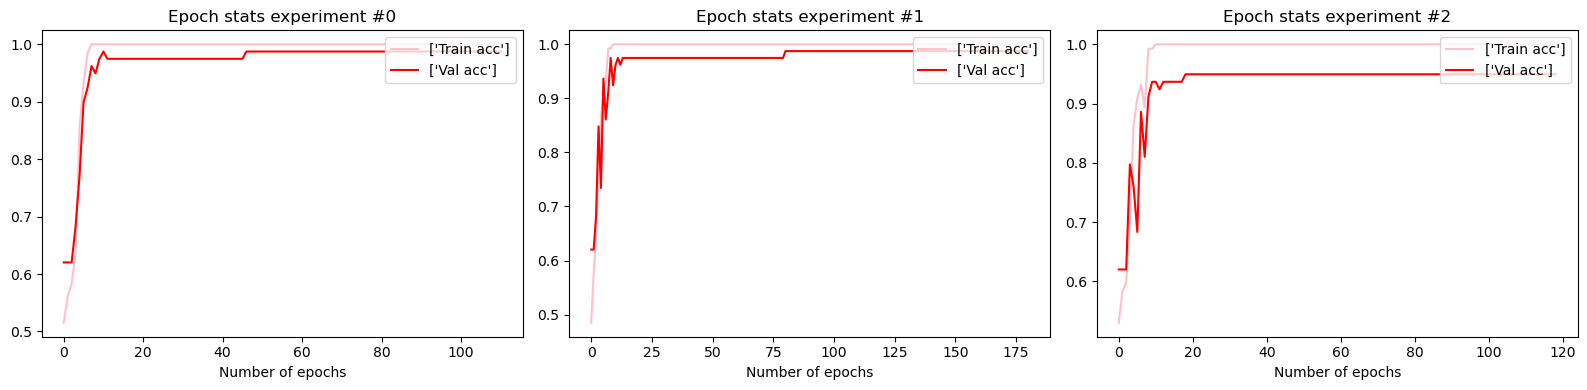

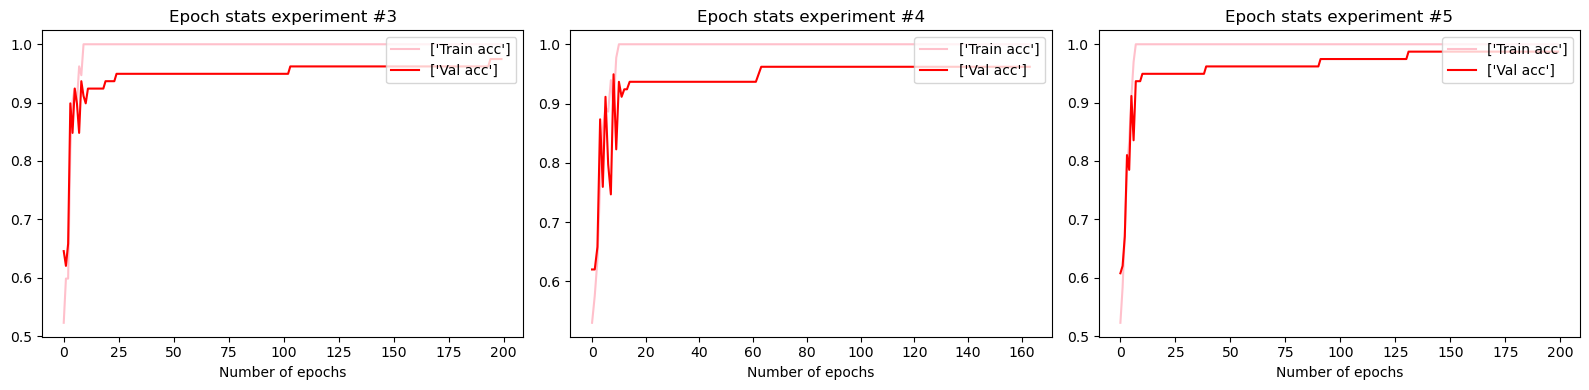

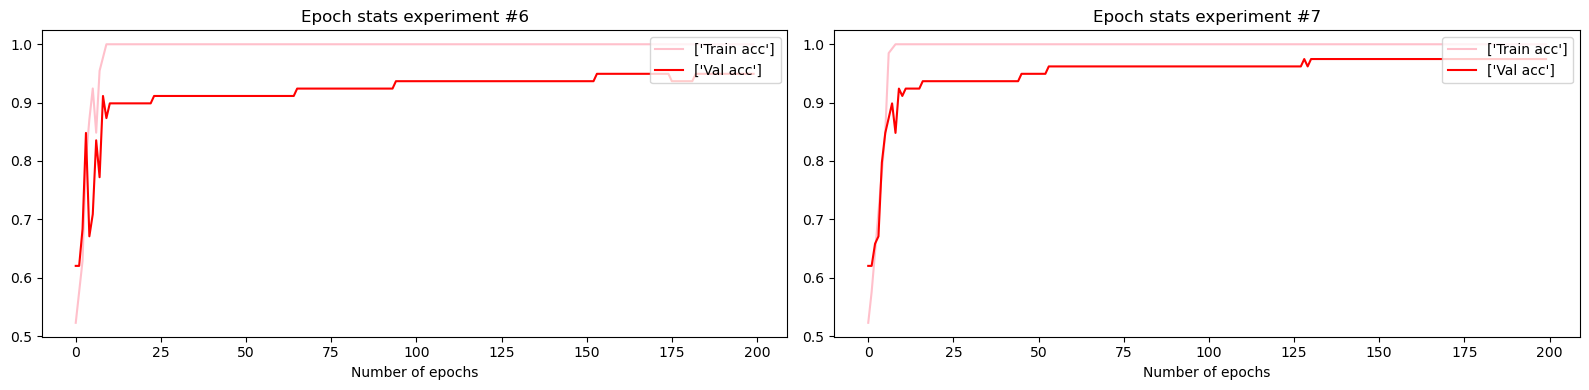

In [50]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

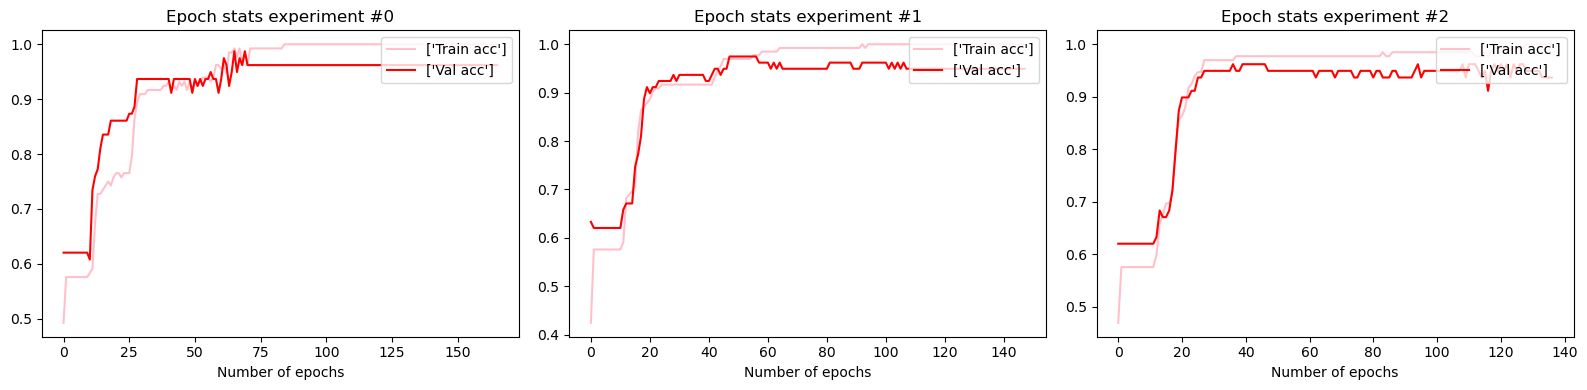

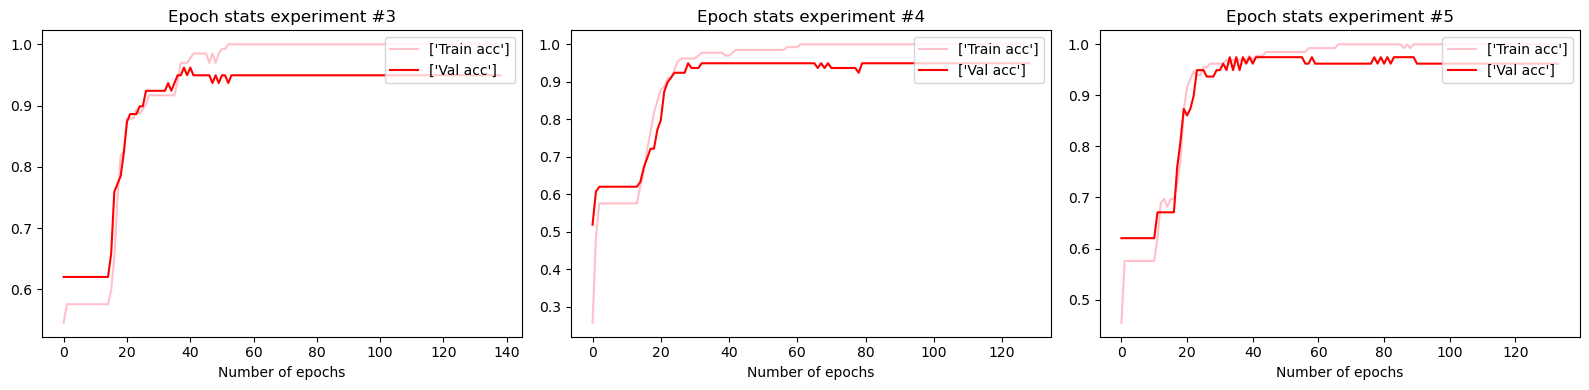

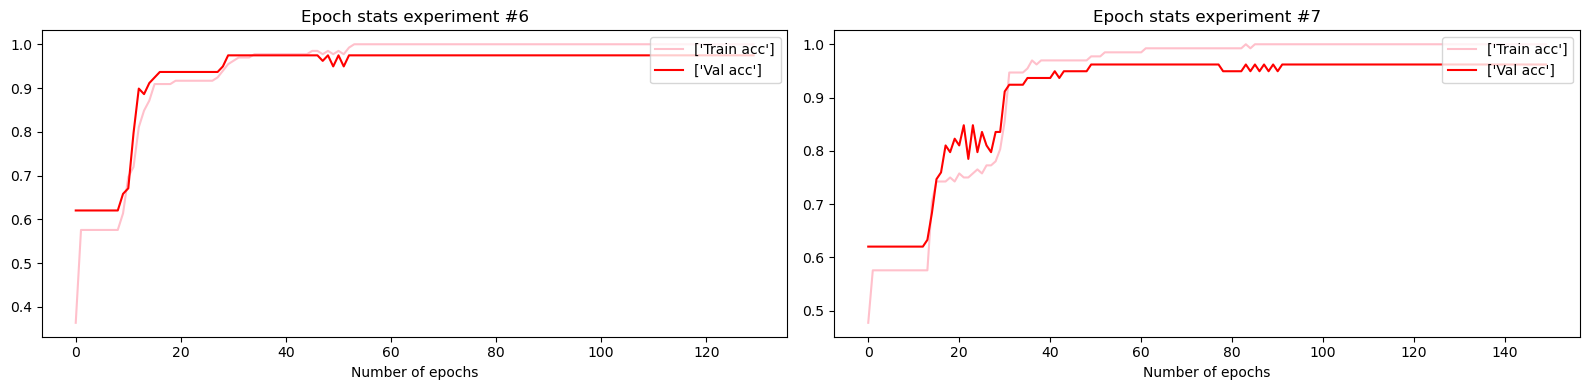

In [51]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSet

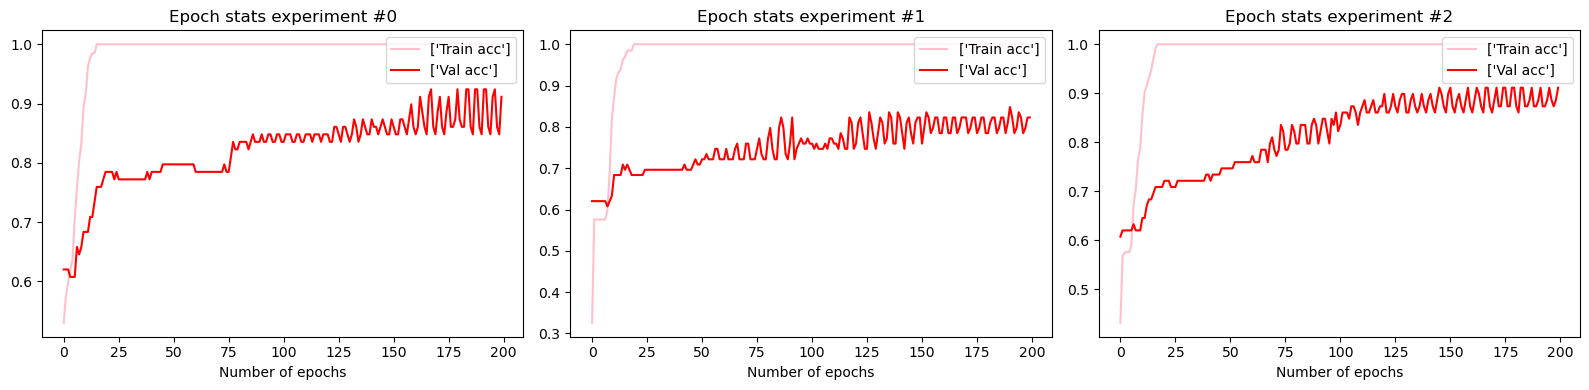

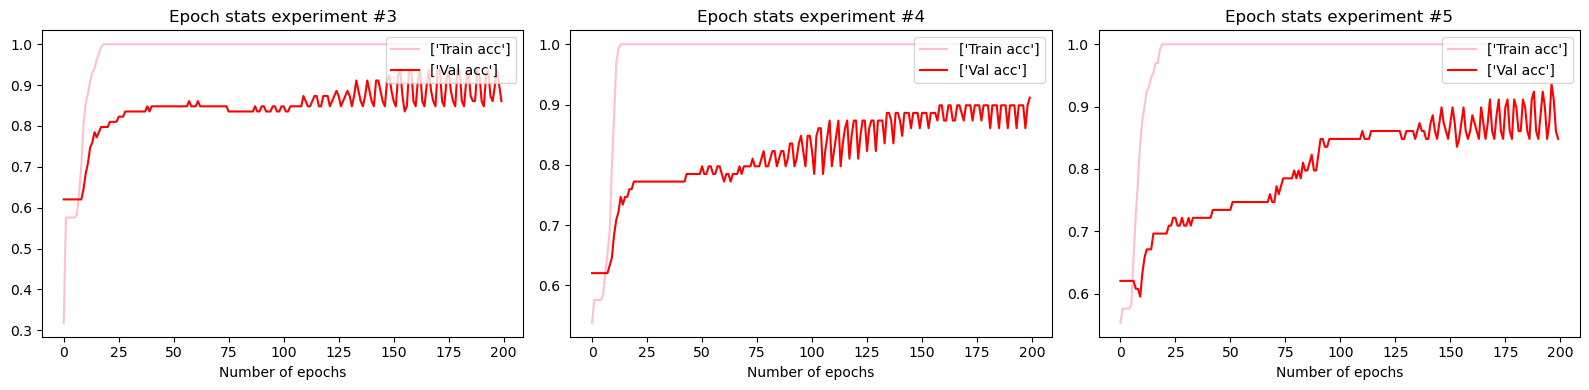

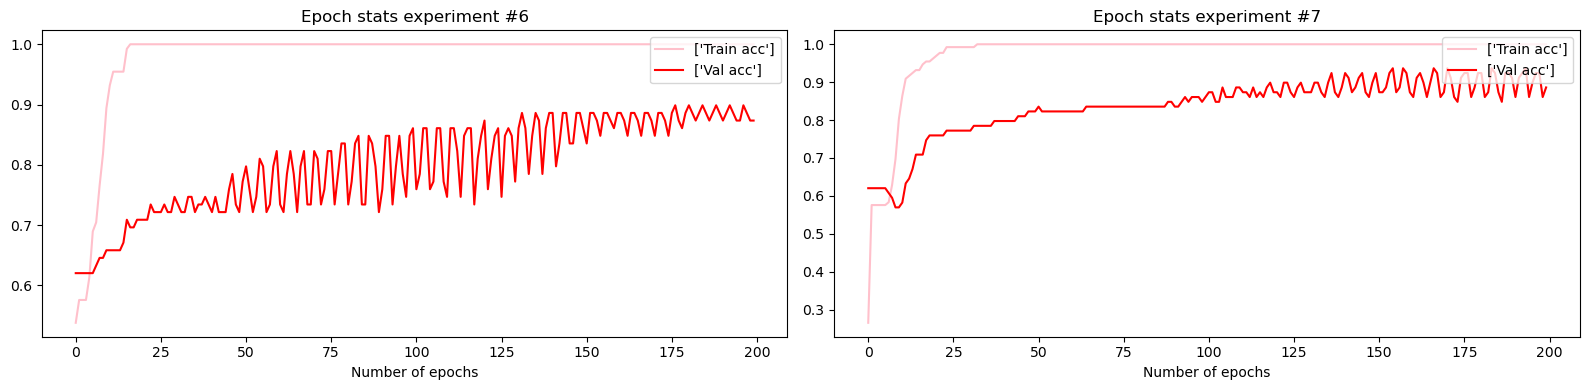

In [52]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### Deepset V2

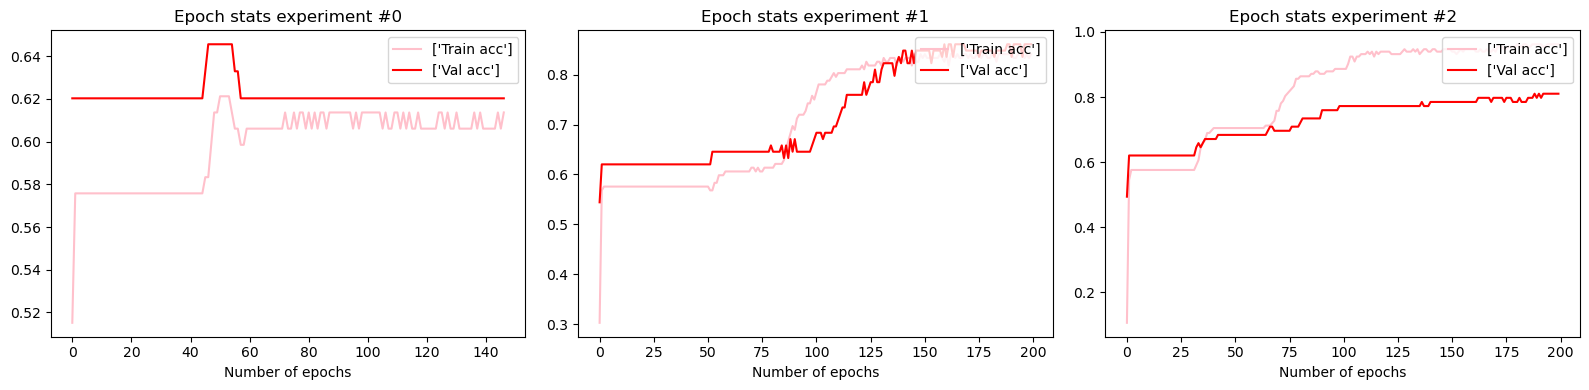

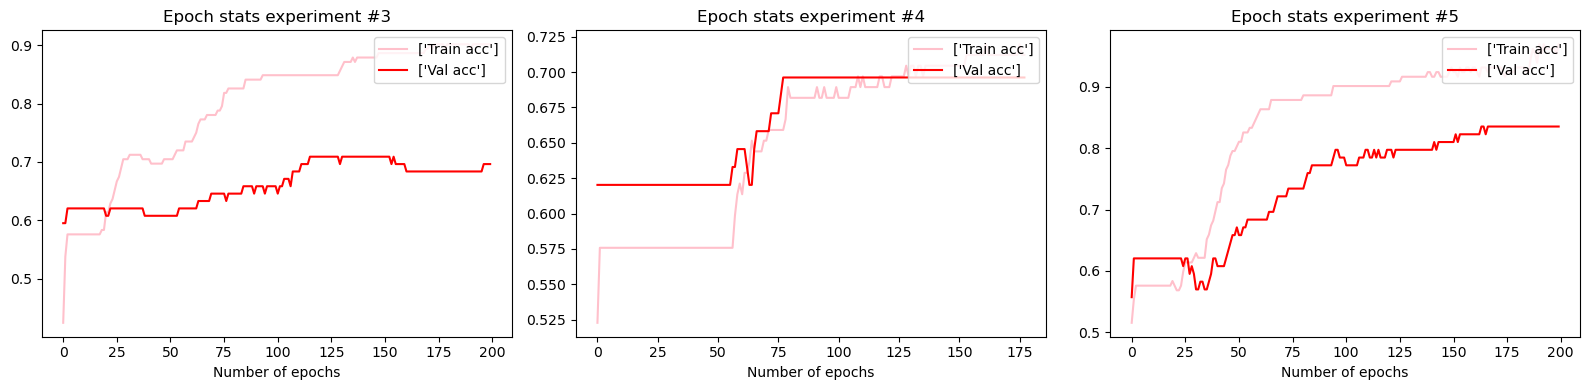

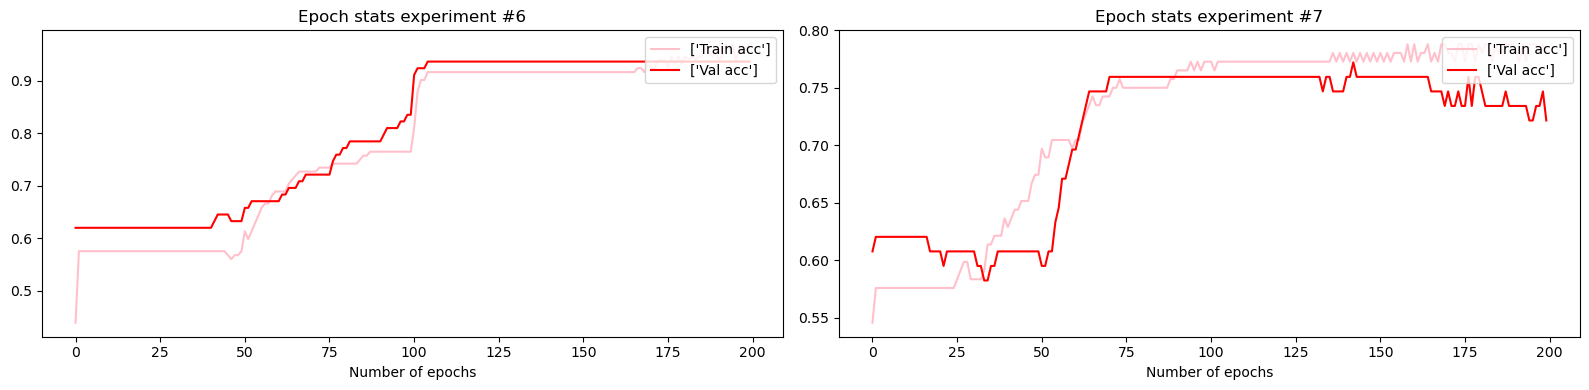

In [53]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedFordward

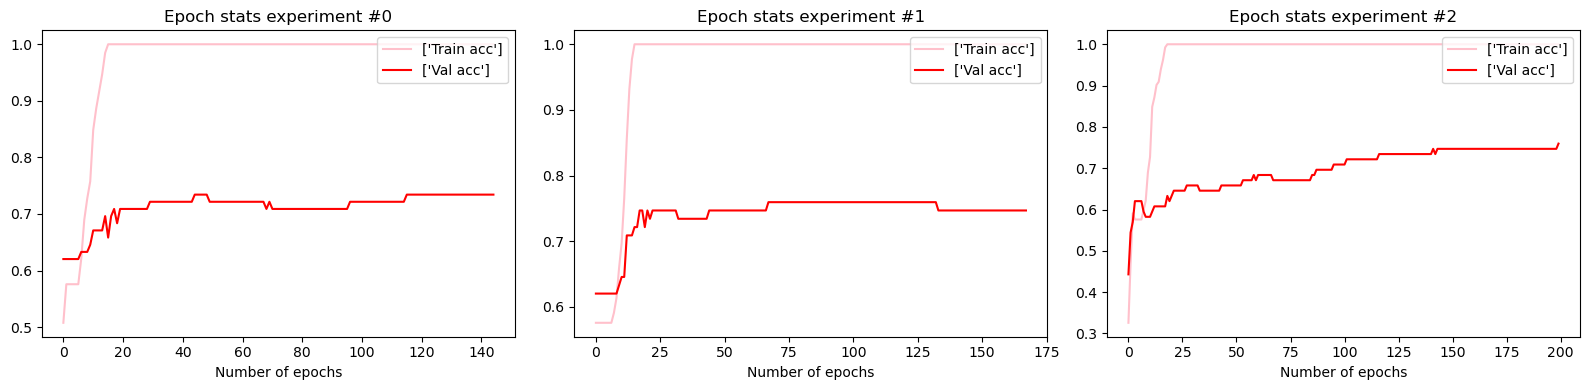

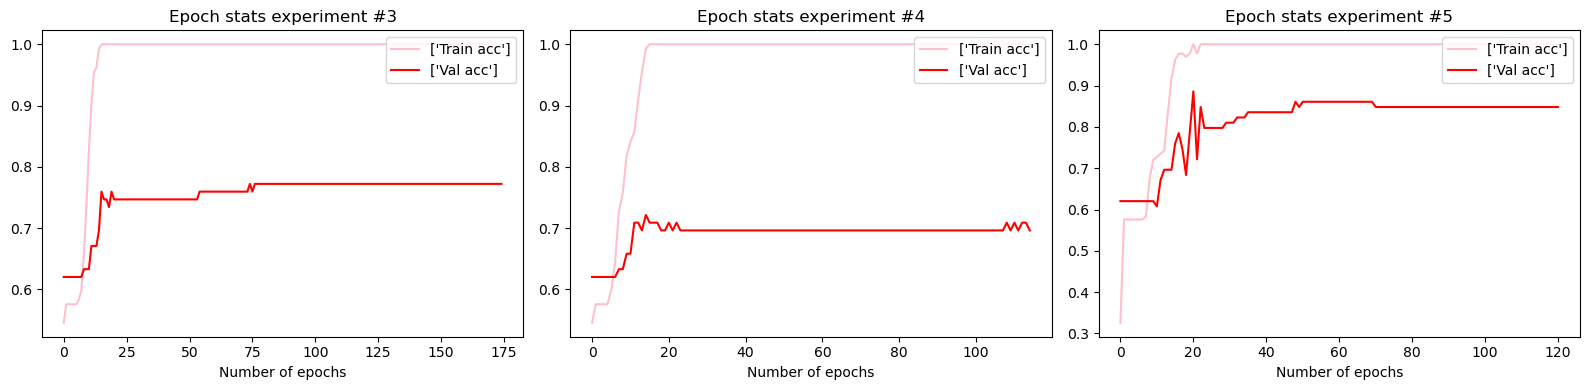

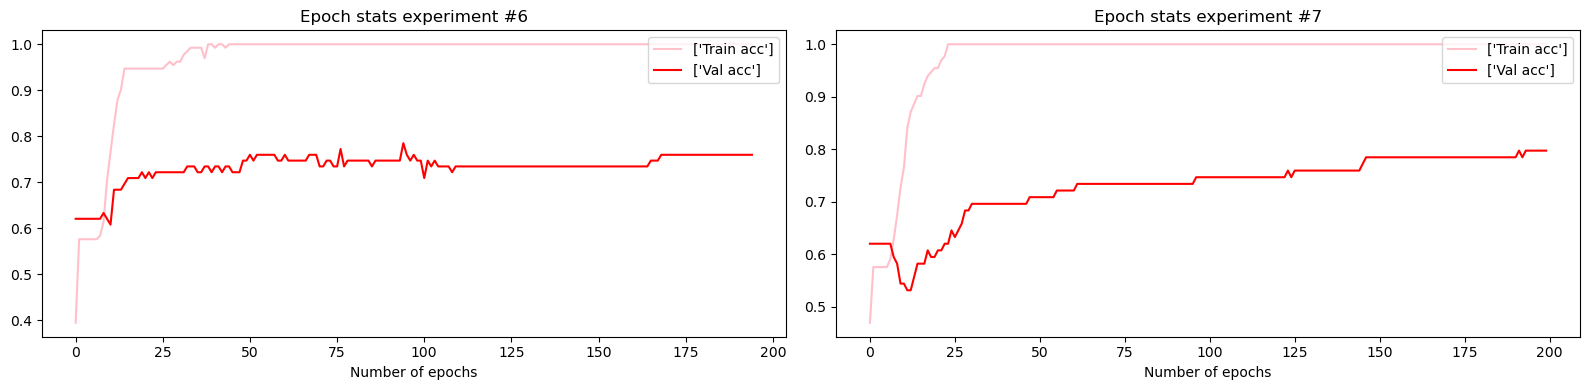

In [54]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)